Arm based on this paper:

https://www-spiedigitallibrary-org.tudelft.idm.oclc.org/journals/optical-engineering/volume-57/issue-04/043113/Comparison-of-multihardware-parallel-implementations-for-a-phase-unwrapping-algorithm/10.1117/1.OE.57.4.043113.full

Works also on LS but adds mechanism to minimize impact of residues
with this source:

https://codeocean.com/capsule/2672585/tree/v1

* insert credits
* explenation on implemetation of C code

Still need to insrt some weights based on the paper, to improve results

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
sys.path.append(os.path.abspath("..")) 

from scipy.fftpack import dctn, idctn

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

# Optics
lam   = 0.532     # wavelength (µm)

from src.cylinder_phase import cylinder_phase_perp_to_z_3d

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   

# Activate for cylinder geometry

R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrapped_used = phi_wrapped

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

ARM


In [7]:
import ctypes

dll_path = r"C:\Users\oheymans\odt-thesis\src\ARM\arm.dll"
lib = ctypes.CDLL(dll_path)

# Try to see if any "unwrap" function is in there
for name in dir(lib):
    if "unwrap" in name.lower():
        print(name)

-23.447269053418314 23.385499380129534


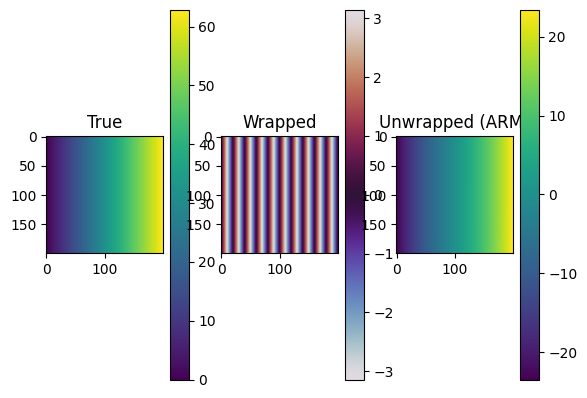

phi_unw shape: (200, 200)
phi_unw min/max: -23.447269053418314 23.385499380129534


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from src.ARM.unwrap_arm import unwrap_phase_ARM

rows, cols = 200, 200
x = np.linspace(0, 20*np.pi, cols)
true_phase = np.tile(x, (rows, 1))
wrapped = np.angle(np.exp(1j * true_phase))
mask = np.ones_like(wrapped, dtype=np.float64)

phi_unw = unwrap_phase_ARM(
    wrapped, mask=mask,
    mu=1.0, lam=0.001,
    nIter=10000, ban_OmegaInit=0
)
print(phi_unw.min(), phi_unw.max())



plt.subplot(1,3,1); plt.imshow(true_phase, cmap="viridis"); plt.title("True"); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(wrapped, cmap="twilight", vmin=-np.pi, vmax=np.pi); plt.title("Wrapped"); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(phi_unw, cmap="viridis"); plt.title("Unwrapped (ARM)"); plt.colorbar()
plt.show()

print("phi_unw shape:", phi_unw.shape)
print("phi_unw min/max:", phi_unw.min(), phi_unw.max())


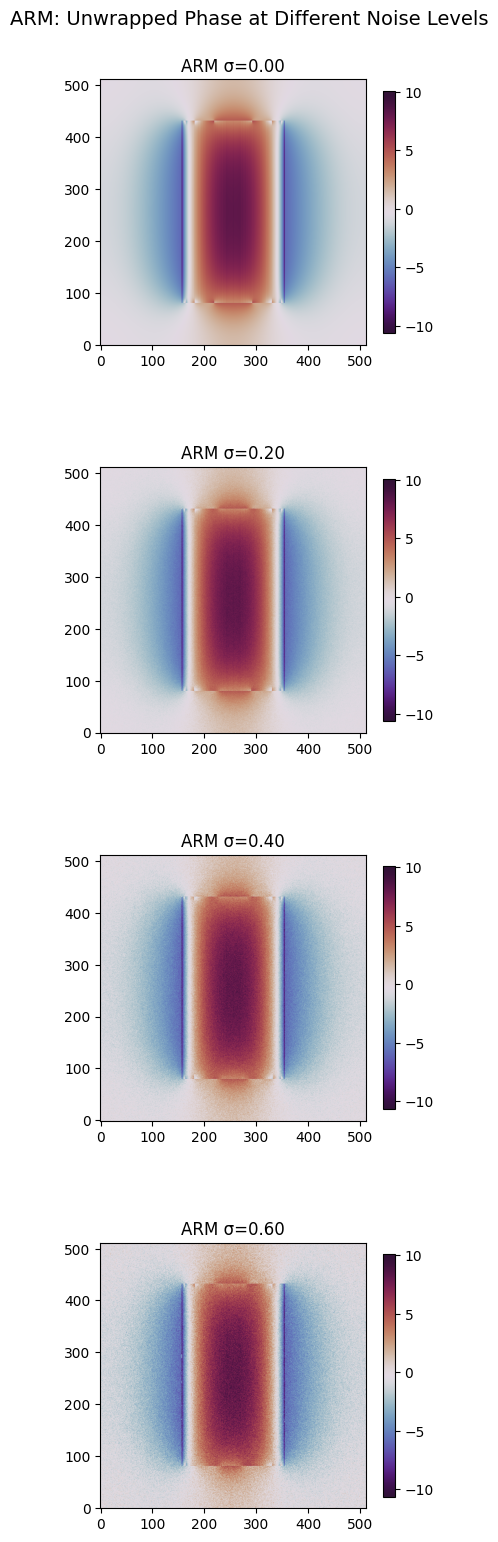

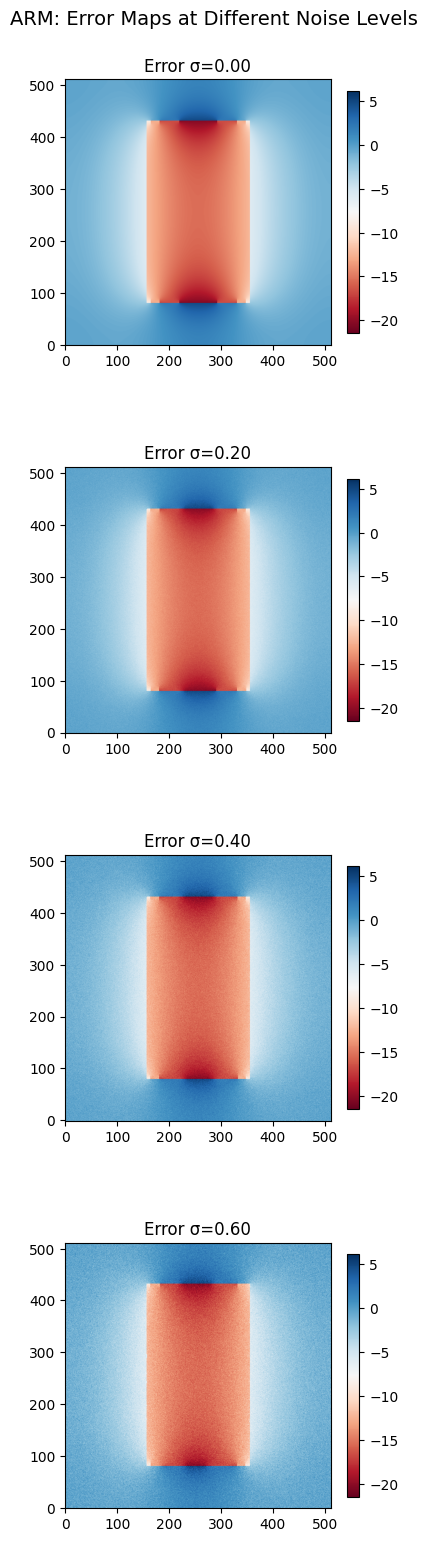

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from src.ARM.unwrap_arm import unwrap_phase_ARM

from sklearn.metrics import root_mean_squared_error

# ----------------------------------------------------------
# Noise levels to test
# ----------------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]
all_results_ARM = {}

for sigma in noise_levels:
    # Add noise to your *wrapped* phase
    phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
    mask = np.ones_like(phi_noisy, dtype=np.float64)

    # Run ARM unwrapping
    phi_u_ARM = unwrap_phase_ARM(
        phi_noisy, mask=mask,
        mu=1.0, lam=0.001,
        nIter=10000, ban_OmegaInit=0
    )

    all_results_ARM[sigma] = (phi_noisy, phi_u_ARM)

# ----------------------------------------------------------
# Plot: ARM unwrapped phases
# ----------------------------------------------------------
all_unwrapped_global = np.concatenate([r.flatten() for (_, r) in all_results_ARM.values()])
vmin_u, vmax_u = np.min(all_unwrapped_global), np.max(all_unwrapped_global)

fig, axes = plt.subplots(len(noise_levels),1, figsize=(4, 4*len(noise_levels)))
for i, (sigma, (phi_noisy, phi_u)) in enumerate(all_results_ARM.items()):
    ax = axes[i]
    im = ax.imshow(phi_u, cmap="twilight_shifted", origin="lower", vmin=vmin_u, vmax=vmax_u)
    ax.set_title(f"ARM σ={sigma:.2f}")
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("ARM: Unwrapped Phase at Different Noise Levels", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Plot: Error maps (vs true phase)
# ----------------------------------------------------------
all_errors_global = np.concatenate([(phi_u - phi_true).flatten() for (_, phi_u) in all_results_ARM.values()])
vmin_e, vmax_e = np.min(all_errors_global), np.max(all_errors_global)

fig, axes = plt.subplots(len(noise_levels), 1, figsize=(4, 4*len(noise_levels)))
for i, (sigma, (phi_noisy, phi_u)) in enumerate(all_results_ARM.items()):
    ax = axes[i]
    err = phi_u - phi_true
    im = ax.imshow(err, cmap="RdBu", origin="lower", vmin=vmin_e, vmax=vmax_e)
    ax.set_title(f"Error σ={sigma:.2f}")
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("ARM: Error Maps at Different Noise Levels", fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
import sys, os, time
import numpy as np
from sklearn.metrics import root_mean_squared_error

def evaluate_phase(phi_true, phi_unwrapped, mask=None):
    if mask is None:
        mask = np.ones_like(phi_true, dtype=bool)

    t = phi_true[mask]
    u = phi_unwrapped[mask]

    offset = np.mean(u - t)
    u_corr = u - offset

    rmse = root_mean_squared_error(t, u_corr)
    return rmse

# Make sure we can import from src/
sys.path.append(os.path.abspath(".."))

# ARM unwrapping
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Fix dtype compatibility (needed for some unwrapping libs)
# ------------------------------------------------------
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]   # radians
n_runs = 7

# Initialize results storage
rmse_results = {sigma: {"ARM": []} for sigma in noise_levels}

# ------------------------------------------------------
# Helpers
# ------------------------------------------------------
def circ_diff(a, b):
    """Circular difference between two phase maps."""
    return np.angle(np.exp(1j * (a - b)))

def rmse_circ(phi_ref, phi_est, mask=None):
    """Circular RMSE between reference and estimate."""
    e = circ_diff(phi_ref, phi_est)
    if mask is not None:
        e = e[mask > 0]
    return float(np.sqrt(np.mean(e**2)))

# ------------------------------------------------------
# Main loop
# ------------------------------------------------------
for sigma in noise_levels:
    for run in range(n_runs):
        # Add noise to your *wrapped* phase
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

    # Run ARM unwrapping
        phi_ARM = unwrap_phase_ARM(
        phi_noisy, mask=mask,
        mu=1.0, lam=0.001,
        nIter=10000, ban_OmegaInit=0)


        # Evaluate
        rmse = evaluate_phase(phi_true, phi_ARM, tissue_mask)
        rmse_results[sigma]["ARM"].append(rmse)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("ARM: Mean RMSE (10 runs each)")
for sigma in noise_levels:
    vals = rmse_results[sigma]["ARM"]
    mean_rmse = np.mean(vals)
    std_rmse  = np.std(vals)
    print(f"σ = {sigma:.2f} → RMSE = {mean_rmse:.4f} ± {std_rmse:.4f} rad")


ARM: Mean RMSE (10 runs each)
σ = 0.00 → RMSE = 1.9638 ± 0.0000 rad
σ = 0.20 → RMSE = 1.9276 ± 0.0117 rad
σ = 0.40 → RMSE = 1.9144 ± 0.0177 rad
σ = 0.60 → RMSE = 1.9394 ± 0.0219 rad


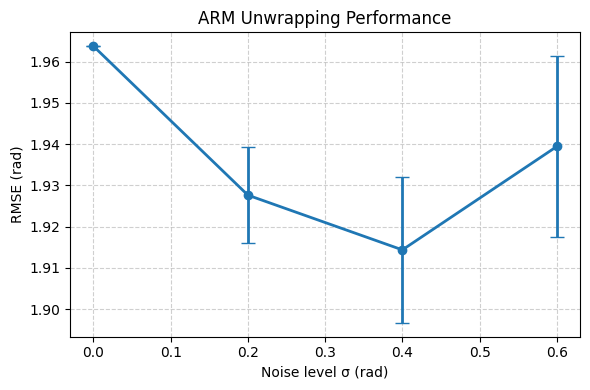

In [17]:
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Plot RMSE vs noise level
# ------------------------------------------------------
means = []
stds = []

for sigma in noise_levels:
    vals = rmse_results[sigma]["ARM"]
    means.append(np.mean(vals))
    stds.append(np.std(vals))

plt.figure(figsize=(6,4))
plt.errorbar(noise_levels, means, yerr=stds, fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Noise level σ (rad)")
plt.ylabel("RMSE (rad)")
plt.title("ARM Unwrapping Performance")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import sys, os, time
import numpy as np
from sklearn.metrics import root_mean_squared_error

def evaluate_phase(phi_true, phi_unwrapped, mask=None):
    if mask is None:
        mask = np.ones_like(phi_true, dtype=bool)

    t = phi_true[mask]
    u = phi_unwrapped[mask]

    offset = np.mean(u - t)
    u_corr = u - offset

    rmse = root_mean_squared_error(t, u_corr)
    return rmse

# Make sure we can import from src/
sys.path.append(os.path.abspath(".."))

# ARM unwrapping
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Fix dtype compatibility (needed for some unwrapping libs)
# ------------------------------------------------------
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]   # radians
n_runs = 7

# Initialize results storage
rmse_results = {sigma: {"ARM": []} for sigma in noise_levels}

# ------------------------------------------------------
# Helpers
# ------------------------------------------------------
def circ_diff(a, b):
    """Circular difference between two phase maps."""
    return np.angle(np.exp(1j * (a - b)))

def rmse_circ(phi_ref, phi_est, mask=None):
    """Circular RMSE between reference and estimate."""
    e = circ_diff(phi_ref, phi_est)
    if mask is not None:
        e = e[mask > 0]
    return float(np.sqrt(np.mean(e**2)))

# ------------------------------------------------------
# Main loop
# ------------------------------------------------------
for sigma in noise_levels:
    for run in range(n_runs):
        # Add noise to your *wrapped* phase
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

    # Run ARM unwrapping
        phi_ARM = unwrap_phase_ARM(
        phi_noisy, mask=mask,
        mu=1.0, lam=0.001,
        nIter=10000, ban_OmegaInit=0)


        # Evaluate
        rmse = evaluate_phase(phi_true, phi_ARM, tissue_mask)
        rmse_results[sigma]["ARM"].append(rmse)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("ARM: Mean RMSE (10 runs each)")
for sigma in noise_levels:
    vals = rmse_results[sigma]["ARM"]
    mean_rmse = np.mean(vals)
    std_rmse  = np.std(vals)
    print(f"σ = {sigma:.2f} → RMSE = {mean_rmse:.4f} ± {std_rmse:.4f} rad")


ARM: Mean RMSE (10 runs each)
σ = 0.00 → RMSE = 1.9638 ± 0.0000 rad
σ = 0.20 → RMSE = 1.9276 ± 0.0117 rad
σ = 0.40 → RMSE = 1.9144 ± 0.0177 rad
σ = 0.60 → RMSE = 1.9394 ± 0.0219 rad


ARM: RMSE vs iterations (σ = 0.4)
nIter =    500 → RMSE = 4.6418 ± 0.0010 rad
nIter =   1000 → RMSE = 4.1807 ± 0.0020 rad
nIter =   5000 → RMSE = 2.4798 ± 0.0181 rad
nIter =  10000 → RMSE = 1.9154 ± 0.0118 rad
nIter = 100000 → RMSE = 1.4125 ± 0.0091 rad


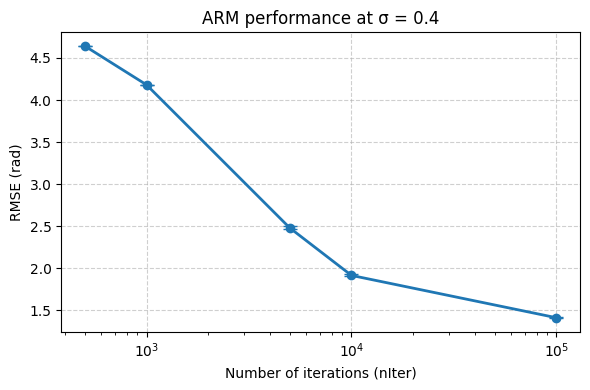

In [15]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# --- Evaluation function ---
def evaluate_phase(phi_true, phi_unwrapped, mask=None):
    if mask is None:
        mask = np.ones_like(phi_true, dtype=bool)
    t = phi_true[mask]
    u = phi_unwrapped[mask]
    offset = np.mean(u - t)
    u_corr = u - offset
    return root_mean_squared_error(t, u_corr)

# --- ARM import ---
sys.path.append(os.path.abspath(".."))
from src.ARM.unwrap_arm import unwrap_phase_ARM

# --- Fix dtype compatibility ---
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
sigma = 0.4             # fixed noise level
n_runs = 5              # number of repeats
iter_list = [500, 1000, 5000, 10000, 100000]

# Storage
rmse_iters = {nIter: [] for nIter in iter_list}

# ------------------------------------------------------
# Main loop
# ------------------------------------------------------
for nIter in iter_list:
    for run in range(n_runs):
        # Add noise to wrapped phase
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

        # Run ARM with varying iterations
        phi_ARM = unwrap_phase_ARM(
            phi_noisy, mask=mask,
            mu=1.0, lam=0.001,
            nIter=nIter, ban_OmegaInit=0
        )

        # Evaluate RMSE
        rmse = evaluate_phase(phi_true, phi_ARM, tissue_mask)
        rmse_iters[nIter].append(rmse)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print(f"ARM: RMSE vs iterations (σ = {sigma})")
for nIter, vals in rmse_iters.items():
    mean_rmse = np.mean(vals)
    std_rmse  = np.std(vals)
    print(f"nIter = {nIter:6d} → RMSE = {mean_rmse:.4f} ± {std_rmse:.4f} rad")

# ------------------------------------------------------
# Plot
# ------------------------------------------------------
means = [np.mean(rmse_iters[n]) for n in iter_list]
stds  = [np.std(rmse_iters[n]) for n in iter_list]

plt.figure(figsize=(6,4))
plt.errorbar(iter_list, means, yerr=stds, fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Number of iterations (nIter)")
plt.ylabel("RMSE (rad)")
plt.title(f"ARM performance at σ = {sigma}")
plt.xscale("log")  # log-scale helpful if list spans large range
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
